In [17]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# --- Define the custom pastel violet palette ---
PASTEL_VIOLET = ['#b39ddb', '#7e57c2', '#d1c4e9', '#9575cd', '#ede7f6']

# Set plotting style (keeping your preferred style)
sns.set_style('whitegrid')

# Define the file path for the optimized data
parquet_file_path = '../data/electricity/processed/demanddata_combined.parquet'

try:
    # Load the fast, single Parquet file
    df = pd.read_parquet(parquet_file_path)
    print(f"✅ Data Loaded: {len(df):,} records.")
except FileNotFoundError:
    print(f"❌ ERROR: Parquet file not found at {parquet_file_path}.")
    print("ACTION REQUIRED: Ensure the raw CSVs are in '../data/electricity/' and run '01_init_load.ipynb' first.")
    raise

print("\n--- Initial DataFrame Info ---")
df.info(memory_usage='deep')
print("\nDataFrame Head:")
print(df.head())

✅ Data Loaded: 434,590 records.

--- Initial DataFrame Info ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 434590 entries, 0 to 434589
Data columns (total 22 columns):
 #   Column                     Non-Null Count   Dtype         
---  ------                     --------------   -----         
 0   SETTLEMENT_DATE            434590 non-null  datetime64[ns]
 1   SETTLEMENT_PERIOD          434590 non-null  object        
 2   ND                         434590 non-null  object        
 3   TSD                        364462 non-null  float32       
 4   ENGLAND_WALES_DEMAND       434590 non-null  float32       
 5   EMBEDDED_WIND_GENERATION   329422 non-null  float32       
 6   EMBEDDED_WIND_CAPACITY     329422 non-null  float32       
 7   EMBEDDED_SOLAR_GENERATION  294334 non-null  float32       
 8   EMBEDDED_SOLAR_CAPACITY    294334 non-null  float32       
 9   NON_BM_STOR                434590 non-null  int64         
 10  PUMP_STORAGE_PUMPING       434590 non-null  int64   

In [18]:
# --- 2. Rename Columns to snake_case ---
df.columns = df.columns.str.lower().str.replace(' ', '_')
print("\n✅ Columns renamed to snake_case.")

# --- 3. Create Accurate Datetime Index ---

# FIX 1: Convert 'settlement_period' to numeric type.
df['settlement_period'] = df['settlement_period'].astype(int)
print("✅ 'settlement_period' converted to integer (int) type.")

# FIX 2: Ensure the target column 'nd' is numeric before aggregation.
df['nd'] = pd.to_numeric(df['nd'], errors='coerce')
print("✅ Target column 'nd' coerced to numeric (float), converting any stray strings to NaN.")

# Convert the SETTLEMENT_DATE column to datetime objects
df['settlement_date'] = pd.to_datetime(df['settlement_date'])

# Calculate the half-hour time offset from the settlement period (SP).
df['time_offset'] = pd.to_timedelta((df['settlement_period'] - 1) * 30, unit='m')

# Combine the date and the time offset to get the exact half-hourly timestamp
df['datetime'] = df['settlement_date'] + df['time_offset']

# Set the new datetime column as the index and sort it chronologically
df.set_index('datetime', inplace=True)
df.sort_index(inplace=True)

# Drop the now redundant raw time columns
df.drop(columns=['settlement_date', 'settlement_period', 'time_offset'], inplace=True)

print("\n--- Datetime Index Created and Set ---")
print(df.index)

# --- 4. Extract Temporal Features ---
df['year'] = df.index.year
df['month'] = df.index.month
df['day_name'] = df.index.day_name()
df['hour'] = df.index.hour
df['day_of_week'] = df.index.dayofweek
df['is_weekend'] = df['day_of_week'].isin([5, 6]).astype(int)

print("\n✅ Temporal features extracted.")
print(df.head())


✅ Columns renamed to snake_case.
✅ 'settlement_period' converted to integer (int) type.
✅ Target column 'nd' coerced to numeric (float), converting any stray strings to NaN.

--- Datetime Index Created and Set ---
DatetimeIndex(['2001-01-01 00:00:00', '2001-01-01 00:30:00',
               '2001-01-01 01:00:00', '2001-01-01 01:30:00',
               '2001-01-01 02:00:00', '2001-01-01 02:30:00',
               '2001-01-01 03:00:00', '2001-01-01 03:30:00',
               '2001-01-01 04:00:00', '2001-01-01 04:30:00',
               ...
               '2025-10-15 19:00:00', '2025-10-15 19:30:00',
               '2025-10-15 20:00:00', '2025-10-15 20:30:00',
               '2025-10-15 21:00:00', '2025-10-15 21:30:00',
               '2025-10-15 22:00:00', '2025-10-15 22:30:00',
               '2025-10-15 23:00:00', '2025-10-15 23:30:00'],
              dtype='datetime64[ns]', name='datetime', length=434590, freq=None)

✅ Temporal features extracted.
                        nd  tsd  england_w

In [19]:
# --- 5. Missing Values (NaN) Analysis and Imputation ---

print("\n--- Missing Value Count Before Imputation ---")
nan_counts = df.isnull().sum()
print(nan_counts[nan_counts > 0].sort_values(ascending=False))

# **Imputation Strategy:** Time-series linear interpolation.
# Target column updated to 'nd'
cols_to_impute = ['embedded_wind_generation', 'embedded_solar_generation', 'ifa_flow', 'nd']

for col in cols_to_impute:
    if col in df.columns:
        initial_nans = df[col].isnull().sum()
        df[col].interpolate(method='time', inplace=True)
        print(f"  - Interpolated {initial_nans} NaNs in '{col}'.")
        
print("\n✅ NaNs interpolated for key features using time-series linear method.")

# --- TARGET COLUMN FOR VISUALIZATIONS ---
target_col = 'nd' # Using National Demand


--- Missing Value Count Before Imputation ---
scottish_transfer            385680
nsl_flow                     315552
eleclink_flow                315552
viking_flow                  315552
greenlink_flow               315552
embedded_solar_generation    140256
embedded_solar_capacity      140256
ifa2_flow                    140256
britned_flow                 140256
east_west_flow               140256
nemo_flow                    140256
embedded_wind_generation     105168
embedded_wind_capacity       105168
tsd                           70128
moyle_flow                    70128
dtype: int64
  - Interpolated 105168 NaNs in 'embedded_wind_generation'.
  - Interpolated 140256 NaNs in 'embedded_solar_generation'.
  - Interpolated 0 NaNs in 'ifa_flow'.
  - Interpolated 0 NaNs in 'nd'.

✅ NaNs interpolated for key features using time-series linear method.


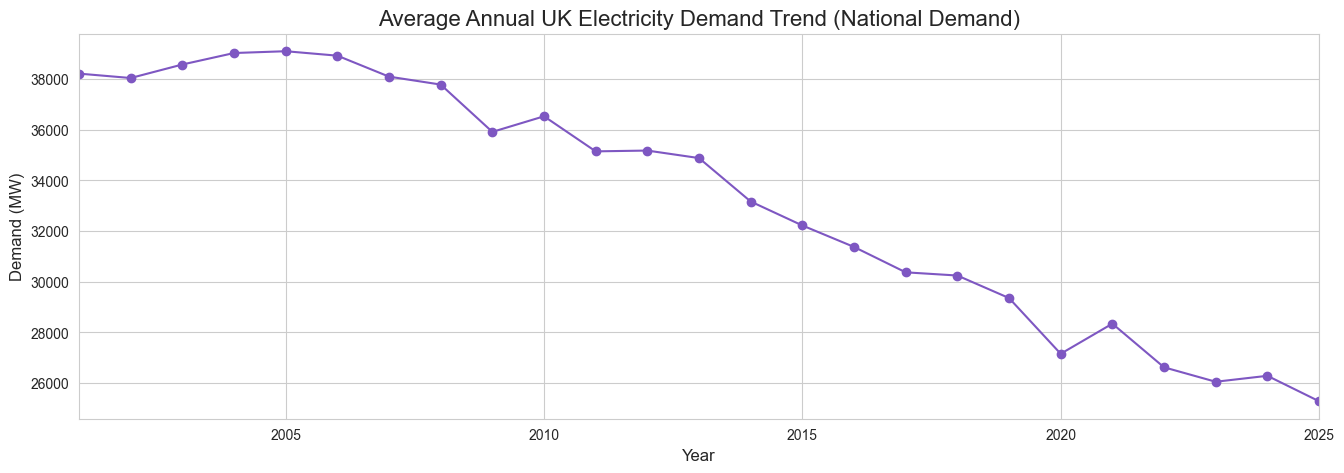

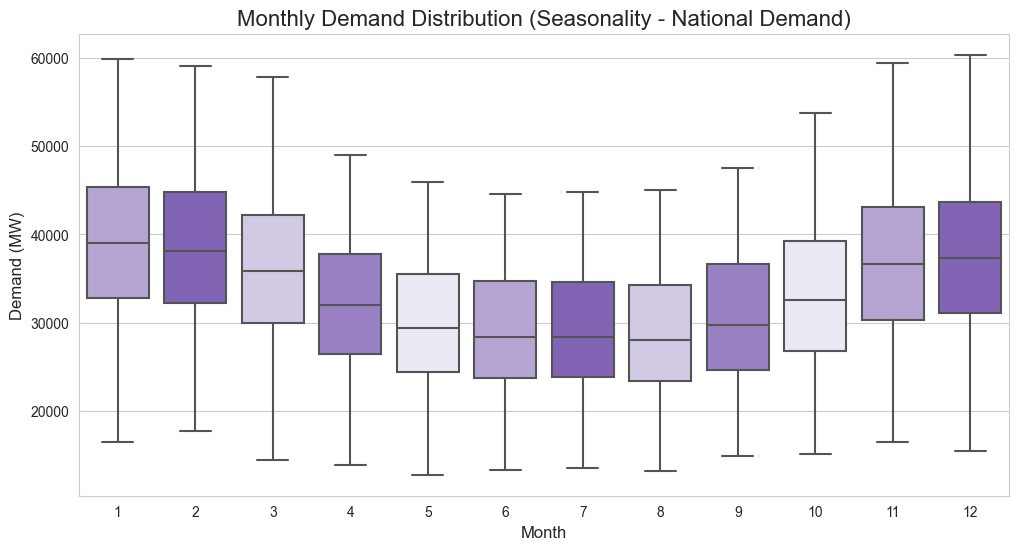

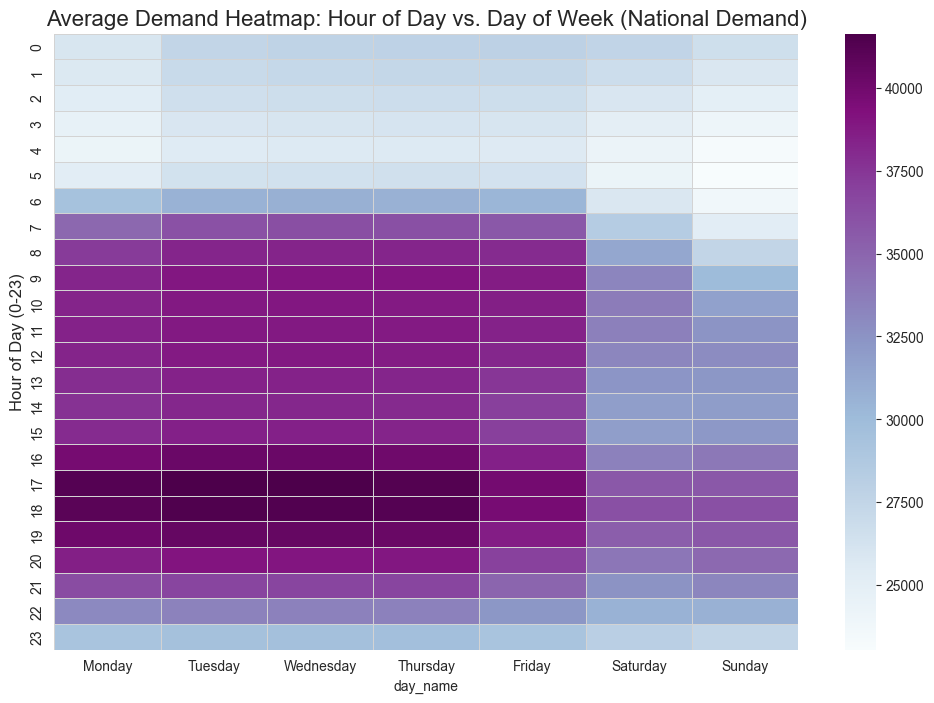

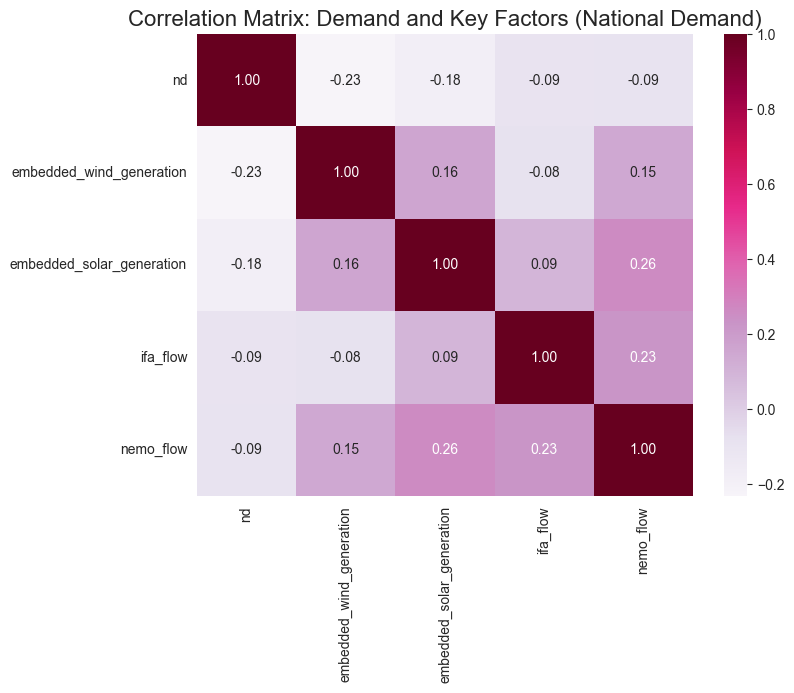

Analysis: Look for strong negative correlations (e.g., Solar vs. Demand) or strong positive correlations (e.g., interconnector flows vs. Demand).

--- EDA Complete ---
Final DataFrame Shape: (434590, 26)


In [20]:
# --- 7. Long-Term Trend (Annual Resampling) ---
plt.figure(figsize=(16, 5))
# --- Pastel Violet Color applied directly ---
df[target_col].resample('Y').mean().plot(marker='o', linestyle='-', color=PASTEL_VIOLET[1])
plt.title('Average Annual UK Electricity Demand Trend (National Demand)', fontsize=16)
plt.ylabel('Demand (MW)', fontsize=12)
plt.xlabel('Year', fontsize=12)
plt.show()

# --- 8. Annual Seasonality (Monthly Boxplot) ---
plt.figure(figsize=(12, 6))
# --- Pastel Violet Palette applied directly ---
sns.boxplot(x='month', y=target_col, data=df, palette=PASTEL_VIOLET)
plt.title('Monthly Demand Distribution (Seasonality - National Demand)', fontsize=16)
plt.xlabel('Month', fontsize=12)
plt.ylabel('Demand (MW)', fontsize=12)
plt.show()

# --- 9. Daily and Weekly Seasonality (Heatmap) ---

# Pivot table for hourly demand by day of week
demand_heatmap = df.pivot_table(
    values=target_col, 
    index='hour', 
    columns='day_name', 
    aggfunc='mean'
)
# Reorder columns for a natural Monday-Sunday flow
day_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
demand_heatmap = demand_heatmap.reindex(columns=day_order)

plt.figure(figsize=(12, 8))
# --- Violet Color Map applied directly ---
sns.heatmap(demand_heatmap, cmap="BuPu", fmt=".0f", linewidths=.5, linecolor='lightgray')
plt.title('Average Demand Heatmap: Hour of Day vs. Day of Week (National Demand)', fontsize=16)
plt.ylabel('Hour of Day (0-23)', fontsize=12)
plt.show()

# --- 10. Feature Correlation (Renewables) ---

# Check how renewables and interconnectors relate to demand
correlation_cols = [
    target_col, 
    'embedded_wind_generation', 
    'embedded_solar_generation', 
    'ifa_flow', # Interconnector flow example
    'nemo_flow' # Another interconnector flow example
]

plt.figure(figsize=(8, 6))
# --- Violet/Red Diverging Map applied directly ---
sns.heatmap(df[correlation_cols].corr(), annot=True, cmap='PuRd', fmt=".2f")
plt.title('Correlation Matrix: Demand and Key Factors (National Demand)', fontsize=16)
plt.show()
print("Analysis: Look for strong negative correlations (e.g., Solar vs. Demand) or strong positive correlations (e.g., interconnector flows vs. Demand).")

# Final check
print("\n--- EDA Complete ---")
print(f"Final DataFrame Shape: {df.shape}")